**Explanation**

## User-Agnostic Item Ranking Algorithm

This notebook implements a user-agnostic item ranking algorithm that aims to find a robust average rating for each item, filtering out potential outliers. The goal is to provide a reliable item ranking that is not biased by individual user variations.

### **How it Works**

1.  **Load Dataset:** The notebook begins by loading a tab-separated dataset containing user-item ratings, including a "normalized\_rating" column.
2.  **Iterate Through Items:** The algorithm then iterates through each unique item in the dataset.
3.  **Iterative Mean Filtering:** For each item, it performs an iterative process:
    * Calculate the mean and standard deviation of the item's ratings.
    * Filter out ratings that deviate significantly (more than one standard deviation) from the mean.
    * Repeat until no more ratings are filtered out (convergence).
4.  **Compute Final Ranking:** The final ranking for each item is determined by the mean of the remaining (filtered) ratings.
5.  **Visualize Results:** The notebook then creates a histogram to visualize the distribution of the calculated item rankings.

### **This notebook will:**

* Load a tab-separated dataset containing user-item ratings.
* Implement a user-agnostic item ranking algorithm.
* Generate a histogram showing the distribution of the resulting item rankings.
* Filter outliers from item ratings to get a more robust mean.

**1.  Imports**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import csv
from collections import defaultdict

**2.    Load Dataset**

In [14]:
# Define dataset path
file_path = "/home/martim/Desktop/tese/datasets/book_crossing/book_ratings_normalized.dat"

# Load dataset
df = pd.read_csv(file_path, sep='\t', header=0)  # Properly use the first row as headers

# Display first few rows
df.head()

item_raters = defaultdict(set)

for item_id, user_id in zip(df['item_id'], df['user_id']):
    item_raters[item_id].add(user_id)


print(item_raters)

defaultdict(<class 'set'>, {6264: {496, 1, 1842, 676}, 4350: {1, 1288, 2058, 1806, 1426, 2206, 682, 939, 1074, 1079, 1084, 63, 2118, 2249, 586, 205, 2404, 879, 497, 1905, 1395, 2035, 2431}, 6252: {1, 1126, 425, 2091, 850, 1910, 1375}, 202: {1, 1283, 1414, 2439, 2824, 2313, 266, 651, 140, 652, 2059, 2572, 1808, 2829, 1426, 1555, 1940, 2324, 2453, 1687, 2579, 153, 154, 1434, 2329, 1821, 2584, 1569, 930, 2340, 2470, 552, 1960, 2216, 2731, 686, 2351, 52, 2484, 2580, 2231, 1720, 187, 1470, 448, 1348, 1093, 1734, 201, 586, 2761, 588, 78, 1489, 2513, 1108, 345, 2137, 731, 2396, 735, 1250, 2531, 2789, 1766, 1895, 489, 2537, 748, 366, 1392, 2035, 884, 1654, 2168, 2558}, 6266: {1, 1412, 495, 505, 218}, 4810: {1, 2342, 301, 2163, 825}, 6251: {1, 2610, 369, 471}, 160: {1, 497, 2804, 726, 1303}, 161: {1, 2165, 353, 695}, 631: {1, 1028, 2309, 1287, 1288, 1415, 267, 1676, 2062, 1553, 539, 416, 1188, 551, 1831, 44, 815, 48, 2486, 2745, 1595, 959, 2883, 1738, 2378, 2380, 974, 1102, 213, 1237, 732, 1502

**3. User-Agnostic Bipartite ranking computation**

In [6]:
def user_agnostic_ranking(tol=1e-6):
    # Output dictionaries
    item_rankings = {}
    filtered_ratings_byItem = defaultdict(list)

    # Group by item and include user_id and normalized_rating
    grouped = df.groupby("item_id")[["user_id", "normalized_rating"]]

    for item, group in grouped:
        # Convert to list of tuples: [(user_id, rating), ...]
        user_ratings = list(zip(group["user_id"], group["normalized_rating"]))
        converged = False

        while not converged:
            # Extract just the ratings for calculation
            ratings_only = [r for _, r in user_ratings]
            μ_i = np.mean(ratings_only)
            σ_i = np.std(ratings_only) if len(ratings_only) > 1 else 0

            # Filter and track removed
            new_user_ratings = []
            removed = []

            for uid, r in user_ratings:
                if (r - μ_i) ** 2 <= σ_i:
                    new_user_ratings.append((uid, r))
                else:
                    removed.append((uid, r))

            # Track filtered ratings
            filtered_ratings_byItem[item].extend(removed)

            # Convergence check
            converged = (len(new_user_ratings) == len(user_ratings))
            user_ratings = new_user_ratings

        # Store final ranking
        final_ratings = [r for _, r in user_ratings]
        item_rankings[item] = np.mean(final_ratings) if final_ratings else np.nan

    return item_rankings, filtered_ratings_byItem


**4.    Compute item rankings**

In [11]:
# Compute rankings using the bipartite ranking algorithm
item_rankings, filtered_ratings_byItem = user_agnostic_ranking()

# Display 10 items
print(item_rankings)


{1: 0.6, 2: 0.8333333333333334, 3: 0.875, 4: 0.7749999999999999, 5: 0.845, 6: 0.8799999999999999, 7: 1.0, 8: 0.36603773584905663, 9: 0.7941176470588235, 10: 0.8032258064516129, 11: 0.9, 13: 0.7200000000000001, 14: 0.9225352112676056, 15: 0.9285714285714286, 16: 0.7666666666666667, 17: 0.9, 18: 0.7666666666666666, 19: 0.7833333333333333, 20: 0.8647058823529411, 21: 0.6285714285714286, 22: 0.8499999999999999, 23: 0.7250000000000001, 24: 0.7142857142857143, 25: 0.8218749999999999, 26: 1.0, 27: 0.6, 28: 0.825, 29: 0.7, 31: 0.77, 32: 0.8142857142857143, 34: 0.7, 35: 0.75, 36: 0.846153846153846, 37: 0.9428571428571428, 38: 0.85625, 39: 0.8, 40: 0.825, 41: 0.7333333333333334, 42: 0.8, 43: 0.8, 44: 0.840625, 45: 0.8, 46: 0.8, 48: 0.8264705882352941, 49: 0.7571428571428572, 50: 0.86, 51: 0.7333333333333334, 52: 0.8, 53: 0.84375, 54: 0.8880000000000001, 55: 0.8272727272727274, 56: 0.8537037037037037, 57: 0.7, 58: 0.7, 59: 0.7499999999999999, 60: 0.7681818181818183, 62: 0.75, 63: 0.75, 64: 0.8229

**5. Visualizing the Distribution of Item Rankings**

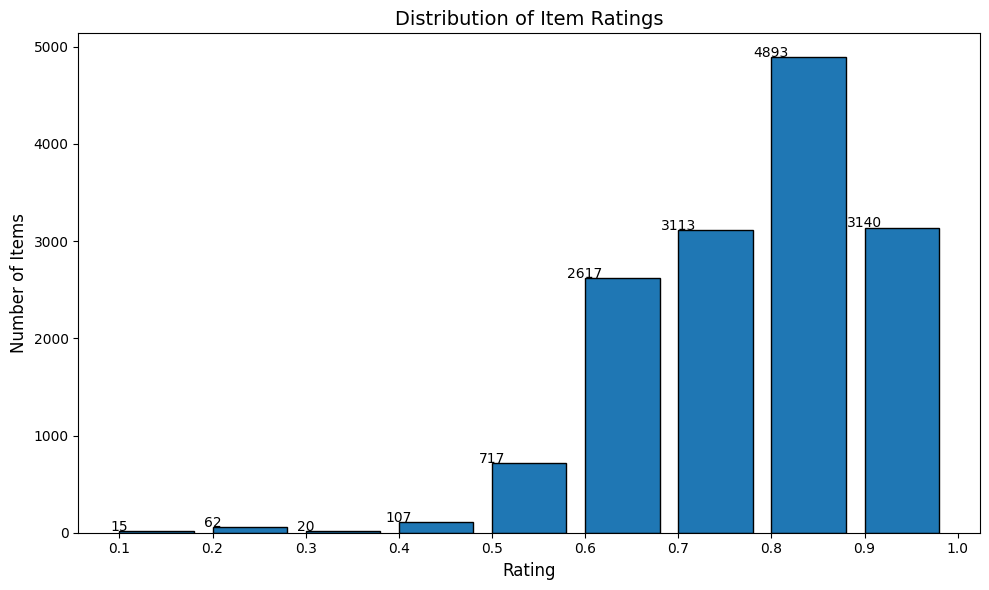

In [8]:
# Extract the ratings from the rankings
ratings = list(rankings.values())

# Define bins for the ratings (from 0.1 to 1.0 with steps of 0.1)
bins = np.arange(0.1, 1.1, 0.1)

# Count how many items fall into each rating bin
hist, bin_edges = np.histogram(ratings, bins=bins)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(hist)):
    plt.text(bin_edges[i], hist[i] + 1, str(hist[i]), ha='center', fontsize=10)

# Finalize the plot
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.title('Distribution of Item Ratings', fontsize=14)
plt.xticks(bins)  # Ensure the x-ticks correspond to the rating bins
plt.tight_layout()
plt.show()


**6.    User Demographics**

In [3]:
# Define age ranges
age_ranges = {
    "< 18": lambda age: age < 18,
    "18-24": lambda age: 18 <= age <= 24,
    "25-34": lambda age: 25 <= age <= 34,
    "35-44": lambda age: 35 <= age <= 44,
    "45-54": lambda age: 45 <= age <= 54,
    ">= 55": lambda age: age >= 55,
}

# Define country to continent mapping
country_to_continent = {
    "usa": "Americas", "united states": "Americas", "united state": "Americas",
    "canada": "Americas", "brazil": "Americas", "dominican republic": "Americas",
    "argentina": "Americas", "mexico": "Americas", "chile": "Americas",
    "venezuela": "Americas", "colombia": "Americas", "peru": "Americas",
    "puerto rico": "Americas", "uruguay": "Americas",
    
    "egypt": "Africa", "south africa": "Africa", "morocco": "Africa",
    "nigeria": "Africa", "tunisia": "Africa",
    
    "china": "Asia/Oceania", "japan": "Asia/Oceania", "australia": "Asia/Oceania",
    "new zealand": "Asia/Oceania", "iran": "Asia/Oceania", "kuwait": "Asia/Oceania",
    "malaysia": "Asia/Oceania", "philippines": "Asia/Oceania", "phillipines": "Asia/Oceania",
    "hong kong": "Asia/Oceania", "singapore": "Asia/Oceania", "taiwan": "Asia/Oceania",
    "india": "Asia/Oceania", "indonesia": "Asia/Oceania", "south korea": "Asia/Oceania",
    "pakistan": "Asia/Oceania", "thailand": "Asia/Oceania", "vietnam": "Asia/Oceania",
    
    "france": "Europe", "germany": "Europe", "united kingdom": "Europe",
    "italy": "Europe", "netherlands": "Europe", "sweden": "Europe",
    "switzerland": "Europe", "spain": "Europe", "norway": "Europe",
    "finland": "Europe", "denmark": "Europe", "portugal": "Europe",
    "romania": "Europe", "russia": "Europe", "poland": "Europe",
    "belgium": "Europe", "austria": "Europe", "iceland": "Europe",
    "czech republic": "Europe", "bulgaria": "Europe", "cyprus": "Europe",
    "greece": "Europe", "ireland": "Europe", "slovakia": "Europe",
    "croatia": "Europe", "hungary": "Europe", "serbia": "Europe",
    
    "far away...": "Unknown", "universe": "Unknown", "burma": "Unknown", "qatar": "Unknown",
    "unknown": "Unknown"
}

def extract_country(location):
    """Extracts the country from the location string by taking the last part."""
    parts = location.lower().split(",")  # Split location by commas
    country = parts[-1].strip() if parts else "unknown"
    return country_to_continent.get(country, "Unknown")  # Return continent or "Unknown"

def process_users_info(file_path):
    """Processes users_info.dat to group users by age range and continent."""
    age_groups = {key: set() for key in age_ranges.keys()}
    continent_groups = {}

    with open(file_path, "r", encoding="utf-8") as file:
        reader = csv.reader(file, delimiter="\t")  # Tab-separated values
        for row in reader:
            if len(row) < 3:
                continue  # Skip malformed rows

            try:
                user_id = int(row[0])  # Convert user_id to integer
                location = row[1]
                age = int(row[2])

                # Process age
                for group, condition in age_ranges.items():
                    if condition(age):
                        age_groups[group].add(user_id)
                        break

                # Process continent
                continent = extract_country(location)
                if continent not in continent_groups:
                    continent_groups[continent] = set()
                continent_groups[continent].add(user_id)

            except ValueError:
                pass  # Skip invalid age or user ID values

    return age_groups, continent_groups

# Example usage
file_path = "/home/martim/Desktop/tese/datasets/book_crossing/users_info.dat"  # Update with actual path
age_groups, continent_groups = process_users_info(file_path)

# Print results
print("Age Groups:", {k: len(v) for k, v in age_groups.items()})
print("age_groups: ", age_groups)
print("Continent Groups:", {k: len(v) for k, v in continent_groups.items()})
print("continent_groups: ", continent_groups)


Age Groups: {'< 18': 84, '18-24': 358, '25-34': 1104, '35-44': 754, '45-54': 392, '>= 55': 253}
age_groups:  {'< 18': {3, 2563, 2565, 1544, 1050, 545, 2083, 2094, 2096, 565, 58, 1083, 1595, 2636, 1109, 2133, 2652, 607, 98, 2147, 621, 2673, 2162, 2168, 2170, 122, 1155, 1668, 646, 654, 660, 1176, 1692, 2206, 2726, 2219, 1196, 2754, 716, 2253, 2766, 1231, 1233, 2782, 2791, 1772, 237, 1271, 2807, 765, 254, 272, 1302, 2854, 1832, 810, 302, 2355, 311, 2377, 2379, 847, 2383, 2384, 2387, 2914, 879, 376, 1915, 1944, 944, 1459, 448, 1986, 461, 973, 2522, 989, 1508, 2539, 1004, 1007, 1022, 2559}, '18-24': {2, 5, 2054, 7, 8, 12, 17, 2066, 23, 28, 29, 2077, 2082, 35, 40, 2091, 2100, 2102, 2103, 62, 2111, 65, 66, 67, 2115, 2118, 2122, 80, 83, 2131, 87, 2136, 2140, 93, 100, 2150, 105, 2154, 2157, 2158, 112, 113, 114, 115, 117, 2171, 2172, 2174, 128, 133, 134, 2181, 138, 140, 141, 2204, 158, 160, 2210, 2220, 175, 2224, 2230, 186, 2240, 192, 194, 2245, 200, 2255, 209, 2258, 211, 2264, 228, 229, 230, 22

**6. Metrics**


**6.1 Effectiveness**

In [12]:
def compute_aggregated_average_ranking(df):
    return df.groupby("item_id")["normalized_rating"].mean().to_dict()

def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Ensure only common items are compared
    
    if len(common_items) < 2:  # Need at least two rankings to compute Kendall's tau
        return 0
    
    sorted_items = sorted(common_items)  # Sort items to ensure consistent order
    
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

# Compute the aggregated average ranking
aa_rankings = compute_aggregated_average_ranking(df)

# Compute Kendall’s tau for the entire dataset
tau_value = compute_kendall_tau(rankings, aa_rankings)
print(f"Kendall’s τ: {tau_value:.4f}")



Kendall’s τ: 0.9797


**6.2   Bias**

In [18]:
def compute_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem):
    """
    Compute B(i) for each item, which is the difference between P_complement(i) and P(i).
    """
    retention_rates = {}

    # Get the users in the demographic group
    target_users = demographic_group[restriction]
    for item, users_who_rated in item_raters.items():
        # Users from the target group who rated the item
        U_i = len(users_who_rated & target_users)        

        # Users from the target group whose ratings got filtered
        filtered_users = {uid for uid, _ in filtered_ratings_byItem.get(item, [])}

        R_i = U_i - len(filtered_users & target_users)  # Retained ratings
        
        # Compute P(i)
        P_i = R_i / U_i if U_i > 0 else 0

        # Compute the complement group (all other users that rated the item but are not in the target group)
        non_target_users = users_who_rated - target_users

        U_complement_i = len(non_target_users)
        R_complement_i = U_complement_i - len(filtered_users & non_target_users)
        

        # Compute P_complement(i)
        P_complement_i = R_complement_i / U_complement_i if U_complement_i > 0 else 0
        
        # Compute B(i) = P_complement(i) - P(i)
        B_i =  abs(P_i - P_complement_i)

        # Store results
        retention_rates[item] = {
            "P(i)": P_i,
            "P_complement(i)": P_complement_i,
            "B(i)": B_i
        }

    return retention_rates

def compute_mean_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem):
    """
    Compute B(g) (mean bias) for a given demographic group.
    """
    bias_results = compute_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem)
    # Sum all B(i) values
    total_bias = sum(item_data["B(i)"] for item_data in bias_results.values())

    # Compute B(g)
    B_g = total_bias / len(bias_results) if bias_results else 0  # Avoid division by zero

    return B_g, bias_results

print("--------------------- AGE_GROUPS ---------------------")
users = set(df["user_id"])

bg, results = compute_mean_bias("< 18", age_groups, item_raters, filtered_ratings_byItem)
print("< 18: ", bg)
bg, results = compute_mean_bias("18-24", age_groups, item_raters, filtered_ratings_byItem)
print("18-24: ", bg)
bg, results = compute_mean_bias("25-34", age_groups, item_raters, filtered_ratings_byItem)
print("25-34: ", bg)
bg, results = compute_mean_bias("35-44", age_groups, item_raters, filtered_ratings_byItem)
print("35-44: ", bg)
bg, results = compute_mean_bias("45-54", age_groups, item_raters, filtered_ratings_byItem)
print("45-54: ", bg)
bg, results = compute_mean_bias(">= 55", age_groups, item_raters, filtered_ratings_byItem)
print(">= 55: ", bg)

print("\n--------------------- CONTINENT ---------------------")
bg, results = compute_mean_bias("Americas", continent_groups, item_raters, filtered_ratings_byItem)
print("Americas: ", bg)
bg, results = compute_mean_bias("Europe", continent_groups, item_raters, filtered_ratings_byItem)
print("Europe: ", bg)
bg, results = compute_mean_bias("Asia/Oceania", continent_groups, item_raters, filtered_ratings_byItem)
print("Asia/Oceania: ", bg)
bg, results = compute_mean_bias("Africa", continent_groups, item_raters, filtered_ratings_byItem)
print("Africa: ", bg)
bg, results = compute_mean_bias("Unknown", continent_groups, item_raters, filtered_ratings_byItem)
print("Unknown: ", bg)


--------------------- AGE_GROUPS ---------------------
< 18:  0.935114374734881
18-24:  0.7769636148158056
25-34:  0.4787051273653315
35-44:  0.5394263462816997
45-54:  0.6009345953501501
>= 55:  0.8295858805958852

--------------------- CONTINENT ---------------------
Americas:  0.7723447303626871
Europe:  0.8561833679803147
Asia/Oceania:  0.9088526450810648
Africa:  0.9980950522261092
Unknown:  0.943527261814387
